# Tugas 4 part 2

### Rafly Faldiansyah Putra
### 210411100063

# 1. Crawling Berita

In [49]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL dari artikel Berita di IDN Times
url = 'https://www.idntimes.com/news/indonesia/muhammad-ilman-nafian-2/jokowi-belum-berani-menggendong-cucu-dari-kaesang-erina'

# Membuat permintaan ke URL
response = requests.get(url)

# Inisialisasi data yang akan disimpan
artikel_mees = []

if response.status_code == 200:
    # Parsing halaman web
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Mengambil judul artikel
    title = soup.find('h1').get_text().strip()
    
    # Mengambil tanggal publikasi artikel dan membersihkan spasi berlebih
    date = soup.find('time').get_text().strip()
    
    # Mengambil isi artikel dengan membersihkan konten tambahan
    content = soup.find_all('p')
    article_text = '\n'.join([p.get_text().strip() for p in content if p.get_text().strip()])

    # Simpan data dalam bentuk dictionary yang telah dibersihkan
    artikel_mees.append({
        'Title': title,
        'Date': date,
        'Content': article_text
    })

# Membuat dataframe dari data yang telah dibersihkan
data_mees = pd.DataFrame(artikel_mees)

# Menampilkan jumlah node (jumlah artikel)
jumlah_node = len(data_mees)
print(f"Jumlah Node (Artikel): {jumlah_node}")

# Menampilkan data setelah crawling dan sebelum pre-processing
print("\nData Setelah Crawling dan Sebelum Pre-processing:")
print(data_mees)

# Menyimpan data ke dalam CSV
csv_filename = "artikel_idn_preprocessing.csv"
data_mees.to_csv(csv_filename, index=False, encoding='utf-8')

print(f"\nData berita telah disimpan ke {csv_filename}")


Jumlah Node (Artikel): 1

Data Setelah Crawling dan Sebelum Pre-processing:
                                               Title               Date  \
0  Jokowi Belum Berani Menggendong Cucu dari Kaes...  16 Oct 24 | 22:45   

                                             Content  
0  Regional\nKategori\nEvent\nDOWNLOAD IDN APP SE...  

Data berita telah disimpan ke artikel_idn_preprocessing.csv


# 2. Pre-processing
Langkah-langkah pre-processing meliputi:

1. Lowercase & Case Folding
2. Cleansing
3. Tokenisasi
4. Stopword Removal
5. Stemming

In [50]:
import re
import string
import pandas as pd
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download resource NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Inisialisasi stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Memuat stopwords Bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Case Folding (sudah dilakukan oleh lowercase)
    
    # 3. Cleansing
    text = text.strip()  # Menghapus whitespace di awal dan akhir
    text = re.sub(f"[{string.punctuation}]", '', text)  # Menghapus tanda baca
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Menghapus karakter non-ASCII
    text = re.sub(r'\s+', ' ', text)  # Menghapus spasi ganda
    
    # 4. Tokenize
    tokens = word_tokenize(text)
    
    # 5. Stopword Removal
    tokens = [word for word in tokens if word not in stop_words]
    
    # 6. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return tokens

# Membaca data dari CSV
data_mees = pd.read_csv("artikel_idn_preprocessing.csv", sep=',', encoding='utf-8')

# Terapkan pre-processing pada kolom 'Content'
data_mees['Tokens'] = data_mees['Content'].apply(preprocess_text)

# Menampilkan hasil pre-processing
print("\nData Setelah Pre-processing:")
print(data_mees[['Title', 'Date', 'Tokens']])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rafly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rafly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Data Setelah Pre-processing:
                                               Title               Date  \
0  Jokowi Belum Berani Menggendong Cucu dari Kaes...  16 Oct 24 | 22:45   

                                              Tokens  
0  [regional, kategori, event, download, idn, app...  


# 3. Model

### 1. Menghitung frekuensi kata dan 10 teratas

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Misal, data_df['Tokens'] merupakan kolom yang berisi token dari setiap dokumen
documents = [' '.join(tokens) for tokens in data_mees['Tokens']]

# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit dan transform data untuk menghitung TF-IDF
tfidf_matrix = vectorizer.fit_transform(documents)

# Mendapatkan daftar kata fitur
feature_names = vectorizer.get_feature_names_out()

# Mendapatkan skor TF-IDF dalam bentuk DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Menghitung rata-rata TF-IDF untuk setiap kata (global)
mean_tfidf = tfidf_df.mean(axis=0)

# Memilih 10 kata dengan nilai TF-IDF rata-rata tertinggi
top_tfidf = mean_tfidf.sort_values(ascending=False).head(10)

# Menampilkan hasil
print("Rank Kata Teratas berdasarkan TF-IDF:", top_tfidf)


Rank Kata Teratas berdasarkan TF-IDF: jokowi      0.470882
kaesang     0.329617
bebingah    0.282529
nama        0.235441
lahir       0.235441
sehat       0.235441
erina       0.188353
sang        0.141264
jakarta     0.141264
putri       0.141264
dtype: float64


### 2. Menghitung matriks cosine

In [77]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Ambil 10 kata teratas dari TF-IDF
top_words = top_tfidf.index.tolist()

# Membuat co-occurrence matrix dengan penimbangan TF-IDF
co_occurrence_weighted = pd.DataFrame(0.0, index=top_words, columns=top_words)

for idx, tokens in enumerate(data_mees['Tokens']):
    # Pilih kata-kata yang ada dalam top_words
    tokens_top = [token for token in tokens if token in top_words]
    # Hitung pasangan kata
    for i in range(len(tokens_top)):
        for j in range(i+1, len(tokens_top)):
            word1 = tokens_top[i]
            word2 = tokens_top[j]
            if word1 != word2:
                # Mengambil nilai TF-IDF untuk masing-masing kata
                tfidf_word1 = tfidf_df.at[idx, word1]  # TF-IDF dari word1
                tfidf_word2 = tfidf_df.at[idx, word2]  # TF-IDF dari word2

                # Menambahkan produk TF-IDF sebagai bobot
                co_occurrence_weighted.at[word1, word2] += tfidf_word1 * tfidf_word2
                co_occurrence_weighted.at[word2, word1] += tfidf_word1 * tfidf_word2

print("Weighted Co-occurrence Matrix:")
print(co_occurrence_weighted)

# Menghitung cosine similarity berdasarkan weighted co-occurrence
cosine_sim_matrix = cosine_similarity(co_occurrence_weighted)
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=top_words, columns=top_words)

print("\nCosine Similarity Matrix:")
print(cosine_sim_df)

# Normalisasi Co-occurrence (jika belum ada)
normalized_co_occurrence = co_occurrence_weighted.div(co_occurrence_weighted.sum(axis=1), axis=0)

# Menyaring top_words untuk hanya memasukkan kata-kata yang ada di normalized_co_occurrence
top_words_filtered = [word for word in top_words if word in normalized_co_occurrence.index]

print("Filtered Top Words:")
print(top_words_filtered)

Weighted Co-occurrence Matrix:
             jokowi    kaesang  bebingah      nama     lahir     sehat  \
jokowi     0.000000  10.864745  7.982262  5.543237  5.543237  5.543237   
kaesang   10.864745   0.000000  3.911308  2.716186  2.716186  2.716186   
bebingah   7.982262   3.911308  0.000000  1.995565  1.995565  1.995565   
nama       5.543237   2.716186  1.995565  0.000000  1.385809  1.385809   
lahir      5.543237   2.716186  1.995565  1.385809  0.000000  1.385809   
sehat      5.543237   2.716186  1.995565  1.385809  1.385809  0.000000   
erina      3.547672   1.738359  1.277162  0.886918  0.886918  0.886918   
sang       1.995565   0.977827  0.718404  0.498891  0.498891  0.498891   
jakarta    1.995565   0.977827  0.718404  0.498891  0.498891  0.498891   
putri      1.995565   0.977827  0.718404  0.498891  0.498891  0.498891   

             erina      sang   jakarta     putri  
jokowi    3.547672  1.995565  1.995565  1.995565  
kaesang   1.738359  0.977827  0.977827  0.977827  
b

### 3. Menghitung Centrality dan Membuat Grafik Kata


Centrality Measures:
          Degree Centrality  Closeness Centrality  Betweenness Centrality
jokowi             1.000000              1.000000                0.011905
kaesang            1.000000              1.000000                0.011905
bebingah           1.000000              1.000000                0.011905
nama               1.000000              1.000000                0.011905
lahir              1.000000              1.000000                0.011905
sehat              1.000000              1.000000                0.011905
erina              1.000000              1.000000                0.011905
sang               0.777778              0.818182                0.000000
jakarta            0.777778              0.818182                0.000000
putri              0.777778              0.818182                0.000000

Jumlah Node (Kata): 10
Jumlah Edges (Hubungan antar Kata): 42


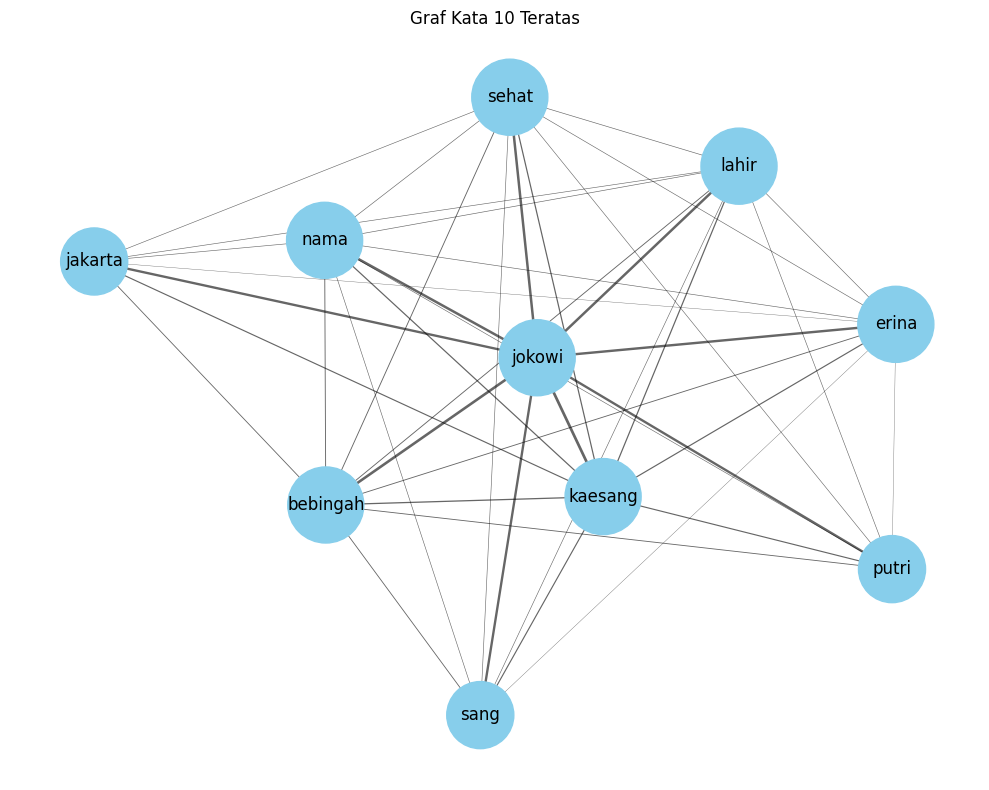

In [78]:
# Membuat graph dengan edge jika similarity di atas threshold
threshold = 0.05  # Set threshold yang diinginkan
G = nx.Graph()

# Menambahkan node
for word in top_words_filtered:
    G.add_node(word)

# Menambahkan edge berdasarkan similarity > threshold
for i in top_words_filtered:
    for j in top_words_filtered:
        if i != j:
            similarity = normalized_co_occurrence.at[i, j]
            if similarity > threshold:
                G.add_edge(i, j, weight=similarity)

# Menghitung centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Menampilkan centrality
centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Closeness Centrality': closeness_centrality,
    'Betweenness Centrality': betweenness_centrality
}).sort_values(by='Degree Centrality', ascending=False)

print("\nCentrality Measures:")
print(centrality_df)

# Menampilkan jumlah node dan edges
jumlah_node_kata = G.number_of_nodes()
jumlah_edges = G.number_of_edges()
print(f"\nJumlah Node (Kata): {jumlah_node_kata}")
print(f"Jumlah Edges (Hubungan antar Kata): {jumlah_edges}")

# Visualisasi Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

node_size = [v * 3000 for v in degree_centrality.values()]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue')

edges = G.edges(data=True)
edge_width = [d['weight'] * 5 for (u, v, d) in edges]
nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6)

nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.title("Graf Kata 10 Teratas")
plt.axis('off')
plt.tight_layout()
plt.show()